In [1]:
# Import

import numpy
import torch
from typing import Tuple
from scipy.optimize import minimize


import sys
sys.path.append('..')

from rcds.statistics import mean, variance, median, biweight_midvariance
from rcds.wrapper import Wrapper
from rcds.rcds import RCDS

import matplotlib.pyplot as plt

torch.set_printoptions(precision=12, sci_mode=True)
print(torch.cuda.is_available())
print(torch.get_num_threads())

dtype = torch.float64
device = 'cpu'

True
6


# Example-01: Objective wrapper

In [2]:
# Define original objective function (input knobs are in original cube)
# Original objective is expected to return a (value, error) tuple
# Expected to return (tensor(nan), _) on 'failure' 

def objective(knobs:torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    x, y = knobs
    value = (x - 5.0)**2 + (y + 5.0)**2
    error = torch.zeros_like(value)
    return value, error

# Evaluate objective

knobs = torch.tensor([+5.0, -5.0], dtype=dtype, device=device)
value, error = objective(knobs)

print(f'knobs={knobs.cpu().numpy()}')
print(f'value={value.cpu().item()}')
print(f'error={error.cpu().item()}')
print()

knobs=[ 5. -5.]
value=0.0
error=0.0



In [3]:
# Wrapper class can be used as a decorator for original objective functions
# Define wrapped objective function (input knobs are assumed to be in unit cube)

@Wrapper(nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[0.0, 0.0], error=1.0E-3)
def objective(knobs:torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    x, y = knobs
    value = (x - 5.0)**2 + (y + 5.0)**2
    error = torch.zeros_like(value)
    return value, error

# Initial evaluation with None or without argument (attach attributes without original objective evaluation)
objective(None)

# Evaluate objective
# Knobs are rescaled with forward (original to unit) or inverse (unit to original)

knobs = torch.tensor([+5.0, -5.0], dtype=torch.float64)
knobs = objective.forward(knobs)
value, error = objective(knobs)

print(f'knobs={knobs.cpu().numpy()}')
print(f'value={value.cpu().item()}')
print(f'error={error.cpu().item()}')
print()

# Several attributes are attached to objective (avalible after evaluation with None or without arguments)
# Also see objective.__dict__

print(f'nk={objective.nk}')                           # nk      -- number of knobs
print(f'lb={objective.lb.cpu().numpy()}')             # lb      -- lower bounds
print(f'ub={objective.ub.cpu().numpy()}')             # ub      -- upper bounds
print(f'dk={objective.dk.cpu().numpy()}')             # dk      -- knobs significance steps (passed to wrapper in units of ogirinal knobs, attached in units of unit knobs)
print(f'error={objective.error.cpu().item()}')        # error   -- objective error (if None, error returned by original objective is used)
print(f'alpha_l1={objective.alpha_l1.cpu().item()}')  # alpha_1 -- l1 regularization factor
print(f'alpha_l2={objective.alpha_l2.cpu().item()}')  # alpha_2 -- l2 regularization factor
print()

# If error parameter is not None, error value returned by original objective is replaced for all subsequent evaluations
# By default, regularization parameters alpha_l1 and alpha_l2 are set to zeros
# Nonzero values can be used to add regularization penalty
# alpha_l1*||knobs||_1 + alpha_l2*||knobs||_2 is added to the returned value of original objective

# Rescale methods are also attached to wrapped objective (avalible after first evaluation)
# Rescale unit knobs and back

print(f'unit knobs {knobs.cpu().numpy()} to original knobs {objective.inverse(knobs).cpu().numpy()}')
print(f'origial knobs {objective.inverse(knobs).cpu().numpy()} to unit knobs {objective.forward(objective.inverse(knobs)).cpu().numpy()}')

knobs=[1. 0.]
value=0.0
error=0.001

nk=2
lb=[-5. -5.]
ub=[5. 5.]
dk=[0. 0.]
error=0.001
alpha_l1=0.0
alpha_l2=0.0

unit knobs [1. 0.] to original knobs [ 5. -5.]
origial knobs [ 5. -5.] to unit knobs [1. 0.]


In [4]:
# Define a numpy wrapper for scipy minimization (objective error is ignored)

def target(knobs:numpy.array, *, dtype:torch.dtype=torch.float64, device:torch.device='cpu') -> numpy.array:
    knobs = torch.tensor(knobs, dtype=dtype, device=device)
    value, _ = objective(knobs)
    return value.cpu().numpy()

knobs = numpy.array([0.5, 0.5])
result = minimize(target, knobs, method='powell')

print(result.x)
print(objective.inverse(torch.tensor(result.x, dtype=torch.float64)))
print(result.fun)

[1. 0.]
tensor([5.000000000000e+00, -5.000000000000e+00], dtype=torch.float64)
0.0


In [5]:
# Objective value sign flip

@Wrapper(sf=True, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[0.1, 0.1], error=1.0E-3)
def objective(knobs:torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    x, y = knobs
    value = (x - 5.0)**2 + (y + 5.0)**2
    error = torch.zeros_like(value)
    return -value, error

objective()
knobs = numpy.array([0.5, 0.5])
result = minimize(target, knobs, method='powell')

print(result.x)
print(objective.inverse(torch.tensor(result.x, dtype=torch.float64)))
print(result.fun)

[1. 0.]
tensor([5.000000000000e+00, -5.000000000000e+00], dtype=torch.float64)
-0.0


In [6]:
# Failure handling
# By convention, original objective is expected to return tensor(nan) on failuer
# In this case additional evaluations can be performed if nk parameter is not zero

# Default nr value is zero and no additional evaluations are performed if returned objective value is tensor(nan)

@Wrapper(cache=True, nr=0, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[0.1, 0.1], error=1.0E-3)
def obj1(knobs:torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    x, y = knobs
    value = (x - 5.0)**2 + (y + 5.0)**2
    error = torch.zeros_like(value)
    value = value if torch.rand(1).item() > 0.5 else torch.tensor(float('nan'), dtype=value.dtype, device=value.device)
    return value, error

# Define objective with additional evaluations

@Wrapper(cache=True, nr=100, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[0.1, 0.1], error=1.0E-3)
def obj2(knobs:torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    x, y = knobs
    value = (x - 5.0)**2 + (y + 5.0)**2
    error = torch.zeros_like(value)
    value = value if torch.rand(1).item() > 0.5 else torch.tensor(float('nan'), dtype=value.dtype, device=value.device)
    return value, error

# Evaluate obj1

obj1()
knobs = torch.tensor([+5.0, -5.0], dtype=torch.float64)
knobs = obj1.forward(knobs)
data = []
for _ in range(10):
    value, error = obj1(knobs)
    data.append(value if value is None else value.item())
print(data)
print()

# Evaluate obj2

obj2()
knobs = torch.tensor([+5.0, -5.0], dtype=torch.float64)
knobs = obj2.forward(knobs)
data = []
for _ in range(10):
    value, error = obj2(knobs)
    data.append(value if value is None else value.item())
print(data)
print()

# Number of evaluations

print(obj1.n)
print(obj2.n)
print()

# Number of total evaluations, including retries

print(obj1.m)
print(obj2.m)
print()

# Cached values
# Note, knobs values are in original box

print(obj1.cache_knobs)
print(obj1.cache_value)
print(obj1.cache_error)
print()

# Save knobs, value and error

knobs, value, error = obj1.save()
print(knobs.cpu().numpy().tolist())
print(value.cpu().numpy().tolist())
print(error.cpu().numpy().tolist())
print()

[nan, 0.0, nan, nan, nan, 0.0, 0.0, 0.0, nan, nan]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

10
10

10
21

[[5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0]]
[nan, 0.0, nan, nan, nan, 0.0, 0.0, 0.0, nan, nan]
[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]

[[5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0], [5.0, -5.0]]
[nan, 0.0, nan, nan, nan, 0.0, 0.0, 0.0, nan, nan]
[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]



In [7]:
# Use Wrapper instance instead of a decorator

def original(knobs:torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    x, y = knobs
    value = (x - 5.0)**2 + (y + 5.0)**2
    error = torch.zeros_like(value)
    return value, error

wrapper = Wrapper(cache=True, nr=100, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[0.1, 0.1], error=1.0E-3)

objective = wrapper(original)
objective()

knobs = torch.tensor([+5.0, -5.0], dtype=torch.float64)
knobs = objective.forward(knobs)
value, error = objective(knobs)
print(value)
print(error)

tensor(0., dtype=torch.float64)
tensor(1.000000000000e-03, dtype=torch.float64)


# Example-02: RCDS parabola workflow

In [8]:
# In this example RCDS parabola fit steps are illustrated
# RCDS optimization uses Powell's method
# 1D optimization is done with minimum bracketing and (weighted) parabola fit

In [9]:
# Define wrapped objective {-0.702014,{x->1.10369,y->-1.10369}}

@Wrapper(cache=True, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[1.0E-9, 1.0E-9], error=1.0E-6)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

# Attach attributes

objective()

# RCDS instance

rcds = RCDS(
    objective,       # -- wrapped objective
    ni=10,           # -- total number of iterations
    np=2,            # -- number of points to use (on both sides) around current bracked minimum for parabola fit region
    ns=4,            # -- max number of additional samples to add into parabola fit region
    sf=0.01,         # -- initial step fraction
    sf_min=0.001,    # -- min step fraction
    sf_max=0.1,      # -- max step fraction
    dr=0.95,         # -- initial step decay rate (updated on each iteration)
    fc=3.0,          # -- comparison factor
    ft=5.0,          # -- threshold factor
    fr=0.1,          # -- close parameter fraction
    ktol=1.0E-9,     # -- knobs termination tolerance
    otol=1.0E-6      # -- objective termination tolerance
)

# Optimization

knobs = torch.tensor([-3.0, 4.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
_, knobs, value, *_ = rcds.fit_rcds(knobs, matrix, termination=True)

exit: triggered value termination at iteration 4


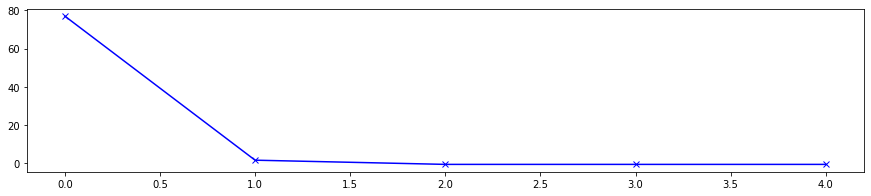

In [10]:
# Plot objective value vs iteration

plt.figure(figsize=(15, 3))
plt.plot(range(len(value)), value.cpu().numpy(), color='blue', marker='x')
plt.show()

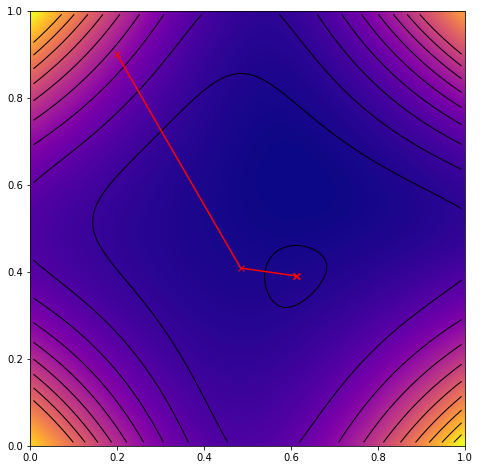

In [11]:
# Plot objective and knobs vs iteration

x = torch.linspace(1.0, 0.0, 64, dtype=dtype, device=device)
y = torch.linspace(1.0, 0.0, 64, dtype=dtype, device=device)
X, Y = torch.meshgrid(x, y, indexing='ij')
Z = torch.tensor([[ objective(torch.stack([x, y])) for x, y in zip(x, y)] for x, y in zip(X, Y)])[..., 0]
L = torch.linspace(0.0, 200.0, 10, dtype=dtype, device=device)

plt.figure(figsize=(8, 8))
plt.imshow(Z.cpu().numpy(), cmap='plasma', interpolation='bilinear', origin='upper', extent=(0, 1, 0, 1))
plt.contour(Z.cpu().numpy(), L.cpu().numpy(), origin='lower', extend='both', linewidths=1, extent=(0, 1, 0, 1), colors='black')
plt.plot(*knobs.T.cpu().numpy(), color='red', marker='x')
plt.show()

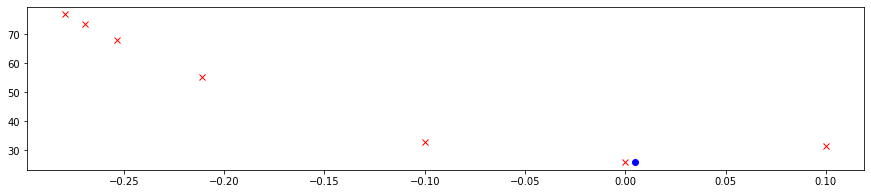

In [12]:
# Detailed 1d minimization step
# The task is to minimize objective(knobs + parameter*vector) with respect to parameter for fixed knobs and vector

rcds = RCDS(objective, np=4, ns=16, dr=0.95, ni=10, ktol=1.0E-9, otol=1.0E-9)

knobs = torch.tensor([-3.0, 4.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
value, error = objective(knobs)

vector = torch.tensor([1.0, 0.0], dtype=rcds.dtype)

# The first step is to bracket minimum for given initial knobs along given direction vector 
# For given initial knobs and vector, valid parameter interval is computed (interval of parameter values for which all knobs remain in the unit cube)
# Given a step fraction, initial step is computed as (step fraction)*(valid interval length)
# Min and max steps are computed as well
# Parameter value is increased until current minimum objective value is less than the value in the positive direction (objective errors is used in comparison)
# If current objective value is less than initial objective value (objective errors is used in comparison), search is terminated
# Else parameter is decreased
# bracket() returns a tuple of parameter values, corresponding knobs, value and error
# Zero parameter index corresponds to current objective minimum

table_alpha, table_knobs, table_value, table_error = rcds.bracket(rcds.sf, knobs, value, error, vector)

# Next, (weighted) parabola fit is performed
# Given number of points (np) around current parameter minimum are used to define new interval
# This interval is sampled, upto new (ns) new points are added
# If added points are close to already known points, this points are removed and objective is computed only for the rest points
# Minimum knobs, value and error are returned (parameter value is not returned)

knobs_min, value_min, error_min = rcds.parabola(vector, table_alpha, table_knobs, table_value, table_error)
alpha_min, _ = (knobs_min - table_knobs[table_alpha == 0.0].flatten())/vector

# Plot result

plt.figure(figsize=(15, 3))
plt.errorbar(table_alpha.cpu().numpy(), table_value.cpu().numpy(), yerr=table_error.cpu().numpy(), fmt=' ', color='red', marker='x')
plt.errorbar(alpha_min.cpu().numpy(), value_min.cpu().numpy(), yerr=error_min.cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.show()

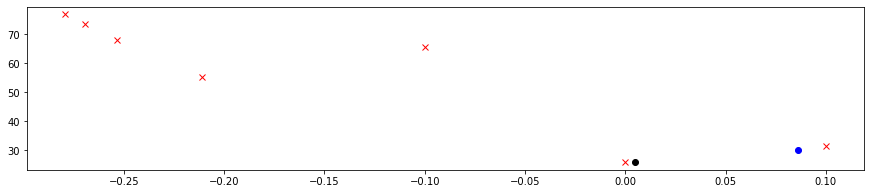

In [13]:
# Optional detector function can be passed to parabola()
# This function is used to filter outliers
# After initial fit this fuction is applied to fit residuals, ft and epsilon parameters are also passed to this function
# This fuction should return a bool mask which is used to multiply weights
# Data is refitted with new weights

# Define detector function
# Note, number of samples should not be to small for correct detector performance

def detector(residual:torch.Tensor, limit:torch.Tensor, tolerance:torch.Tensor) -> torch.Tensor:
    center = median(residual)
    spread = tolerance + biweight_midvariance(residual).sqrt()
    min_value, max_value = center - limit*spread, center + limit*spread
    mask = ((residual > min_value.reshape(-1, 1))*(residual < max_value.reshape(-1, 1))).squeeze()
    return mask

# Add outlier value

table_alpha, table_knobs, table_value, table_error = rcds.bracket(rcds.sf, knobs, value, error, vector)
index = 4
table_value[index] *= 2.0

# Fit without detector

knobs_min, value_min, error_min = rcds.parabola(vector, table_alpha, table_knobs, table_value, table_error)
alpha_min, _ = (knobs_min - table_knobs[table_alpha == 0.0].flatten())/vector

# Fit with detector

knobs_new, value_new, error_new = rcds.parabola(vector, table_alpha, table_knobs, table_value, table_error, detector=detector)
alpha_new, _ = (knobs_new - table_knobs[table_alpha == 0.0].flatten())/vector

# Plot result

plt.figure(figsize=(15, 3))
plt.errorbar(table_alpha.cpu().numpy(), table_value.cpu().numpy(), yerr=table_error.cpu().numpy(), fmt=' ', color='red', marker='x')
plt.errorbar(alpha_min.cpu().numpy(), value_min.cpu().numpy(), yerr=error_min.cpu().numpy(), fmt=' ', color='blue', marker='o')
plt.errorbar(alpha_new.cpu().numpy(), value_new.cpu().numpy(), yerr=error_new.cpu().numpy(), fmt=' ', color='black', marker='o')
plt.show()

# blue  -- without detector
# black -- with detector

# Example-03: RCDS basic

In [14]:
# Minimize quadratic objective function {-2., {x -> 2., y -> -2.}}

@Wrapper(cache=True, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[1.0E-12, 1.0E-12], error=1.0E-12)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y
    error = torch.zeros_like(value)
    return value, error

def hessian():
    return torch.tensor([[2.0, 1.0], [1.0, 2.0]], dtype=dtype)

# Unit vectors
# Minimum is reached at the 2nd iteration, exit trigged at the 3rd iteration

objective()
rcds = RCDS(objective, dr=1.0, ni=10, ktol=1.0E-6, otol=1.0E-6)
knobs = torch.tensor([-3.0, 4.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
sf, knobs, value, error, matrix = rcds.fit_rcds(knobs, matrix, termination=True)
for i, (x, y) in enumerate(zip(knobs, value)):
    print(i, *objective.inverse(x).cpu().numpy(), y.cpu().numpy())
print()

# Hessian eigenvectors
# Minimum is reached at the 1st iteration, exit trigged at the 2nd iteration

objective()
rcds = RCDS(objective, dr=1.0, ni=10, ktol=1.0E-6, otol=1.0E-6)
knobs = torch.tensor([-3.0, 4.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.real(torch.linalg.eig(hessian()).eigenvectors)
sf, knobs, value, error, matrix = rcds.fit_rcds(knobs, matrix, termination=True)
for i, (x, y) in enumerate(zip(knobs, value)):
    print(i, *objective.inverse(x).cpu().numpy(), y.cpu().numpy())
print()

exit: triggered knobs termination at iteration 3
0 -3.0 4.0 29.0
1 -0.4098360655737645 -1.8278688524590203 3.4221311475409637
2 1.9999999999999982 -1.9999999999999982 -2.0
3 1.9999999999999982 -1.9999999999999982 -2.0

exit: triggered knobs termination at iteration 2
0 -3.0 4.0 29.0
1 2.0000000000000018 -2.0000000000000018 -2.0
2 2.0000000000000018 -2.0000000000000018 -2.0



In [15]:
# Minimize nonlinear objective function {-0.702014, {x->1.10369, y->-1.10369}}

@Wrapper(cache=True, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[1.0E-12, 1.0E-12], error=1.0E-12)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

def hessian(knobs):
    x, y = knobs
    return torch.tensor([[2.0 + 2.0/3.0*y**2, 1.0 + 4.0/3.0*x*y], [1.0 + 4.0/3.0*x*y, 2.0 + 2.0/3.0*x**2]])

# Unit vectors

objective()
rcds = RCDS(objective, dr=1.0, ni=10, ktol=1.0E-6, otol=1.0E-6)
knobs = torch.tensor([-3.0, 4.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
sf, knobs, value, error, matrix = rcds.fit_rcds(knobs, matrix, termination=True)
for i, (x, y) in enumerate(zip(knobs, value)):
    print(i, *objective.inverse(x).cpu().numpy(), y.cpu().numpy())
print()

# Hessian eigenvectors

objective()
rcds = RCDS(objective, dr=1.0, ni=10, ktol=1.0E-6, otol=1.0E-6)
knobs = torch.tensor([-3.0, 4.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.real(torch.linalg.eig(hessian(knobs)).eigenvectors)
sf, knobs, value, error, matrix = rcds.fit_rcds(knobs, matrix, termination=True)
for i, (x, y) in enumerate(zip(knobs, value)):
    print(i, *objective.inverse(x).cpu().numpy(), y.cpu().numpy())
print()

exit: triggered value termination at iteration 5
0 -3.0 4.0 77.0
1 -0.15789473684210442 -0.9134615384615401 1.4993740677604914
2 1.1397294625418937 -1.0955135022306193 -0.7002836870807185
3 1.1040959846802645 -1.1036129042892604 -0.7020132908411769
4 1.1028294711963307 -1.1030572676408297 -0.702011537294662
5 1.1024340185297348 -1.103713410632877 -0.7020112845857034

exit: triggered value termination at iteration 3
0 -3.0 4.0 77.0
1 1.0707276123141565 -1.0899535851575894 -0.699952591494515
2 1.102913816347061 -1.1031158828265033 -0.7020118948263103
3 1.1027926030671722 -1.103324492185045 -0.7020119599504502



1163
-629.9999999999999

exit: triggered knobs termination at iteration 2
899
-629.8501972127602


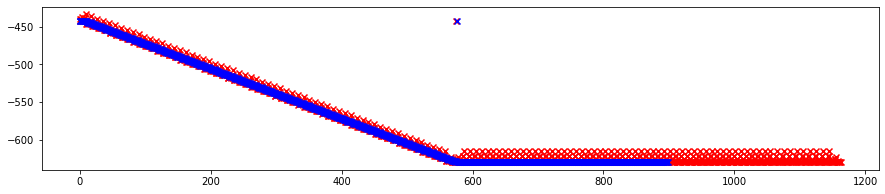

In [16]:
# Minimize multidimensional objective fuction
# Compare RCDS parabola with minimize('powell')

# Set number of knobs and knobs parameters

nk = 64
lb = [-10.0 for _ in range(nk)]
ub = [+10.0 for _ in range(nk)]
dk = [1.0E-3 for _ in range(nk)]

# Set objective function

def objective(knobs:torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    value = torch.zeros_like(knobs.sum())
    error = torch.zeros_like(knobs.sum())
    for i in range(len(knobs) - 1):
        value -= 10.0*torch.exp(-0.25*torch.sqrt(knobs[i]**2 + knobs[i + 1]**2))
    return value, error


# Powell

obj1 = Wrapper(cache=True, nk=nk, lb=lb, ub=ub, dk=dk, error=1.0E-6)(objective)
obj1()
rcds1 = RCDS(obj1, otol=1.0E-3)
knobs = torch.tensor([1.0 for _ in range(rcds1.nk)], dtype=rcds1.dtype)
knobs = obj1.forward(knobs)
matrix = torch.eye(rcds1.nk, dtype=rcds1.dtype)
result = rcds1.fit_scipy(knobs)
print(result.nfev)
print(result.fun)
print()

# RCDS

obj2 = Wrapper(cache=True, nk=nk, lb=lb, ub=ub, dk=dk, error=1.0E-3)(objective)
obj2()
rcds2 = RCDS(obj2, sf=0.005, dr=0.95, ni=64, ktol=1.0E-3, otol=1.0E-3)
knobs = torch.tensor([1.0 for _ in range(rcds2.nk)], dtype=rcds2.dtype)
knobs = obj2.forward(knobs)
matrix = torch.eye(rcds2.nk, dtype=rcds2.dtype)
_, knobs, value, error, matrix = rcds2.fit_rcds(knobs, matrix)
print(rcds2.eval_count)
print(value[-1].cpu().item())

# Compare all objective evaluations

plt.figure(figsize=(15, 3))
plt.scatter(range(obj1.n), obj1.cache_value, color='red', marker='x')
plt.scatter(range(obj2.n), obj2.cache_value, color='blue', marker='x')
plt.show()

269
-629.0251329657353



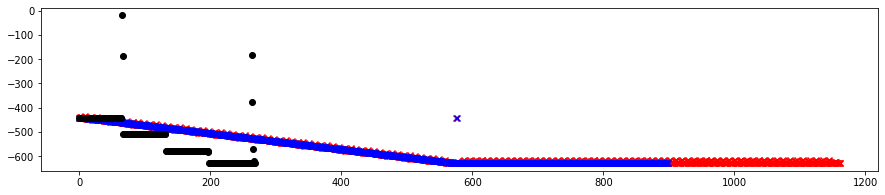

In [17]:
# Other scipy bounded minimize methods can be passed to fit_scipy
# ('powell', 'Nelder-Mead', 'L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr')

method = 'SLSQP'

obj = Wrapper(cache=True, nk=nk, lb=lb, ub=ub, dk=dk, error=1.0E-6)(objective)
obj()
rcds = RCDS(obj, otol=1.0E-3)
knobs = torch.tensor([1.0 for _ in range(rcds.nk)], dtype=rcds.dtype)
knobs = obj.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
result = rcds.fit_scipy(knobs, method=method)
print(result.nfev)
print(result.fun)
print()

plt.figure(figsize=(15, 3))
plt.scatter(range(obj1.n), obj1.cache_value, color='red', marker='x')
plt.scatter(range(obj2.n), obj2.cache_value, color='blue', marker='x')
plt.scatter(range(obj.n), obj.cache_value, color='black', marker='o')
plt.show()

# Example-04: RCDS for noisy objective

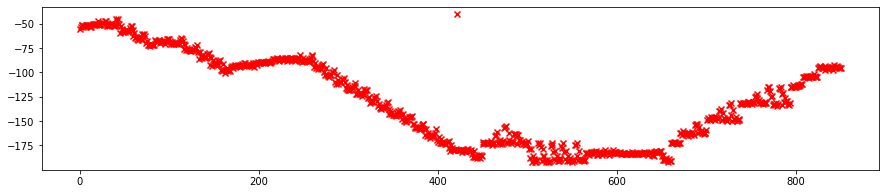

exit: triggered value termination at iteration 5


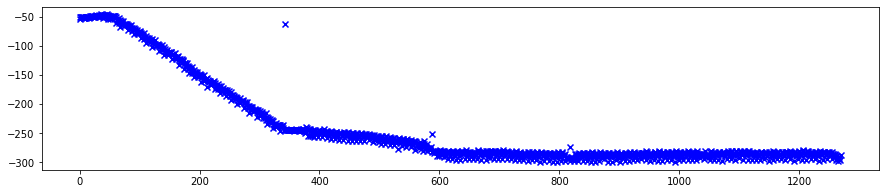

In [18]:
plt.figure(figsize=(15, 3))

# Set number of knobs and knobs parameters

nk = 32
lb = [-50.0 for _ in range(nk)]
ub = [+50.0 for _ in range(nk)]
dk = [1.0E-3 for _ in range(nk)]

error = 1.0

# Set objective function

@Wrapper(cache=True, nk=nk, lb=lb, ub=ub, dk=dk, error=error)
def objective(knobs:torch.Tensor, error=error) -> Tuple[torch.Tensor, torch.Tensor]:
    value = torch.zeros_like(knobs.sum())
    error = error*torch.ones_like(knobs.sum())
    for i in range(len(knobs) - 1):
        value -= 10.0*torch.exp(-0.25*torch.sqrt(knobs[i]**2 + knobs[i + 1]**2))
    return value + error*torch.randn_like(error), error

# Powell

objective()
rcds = RCDS(objective, ktol=1.0E-3, otol=1.0E-3)
knobs = torch.tensor([5.0 for _ in range(rcds.nk)], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
result = rcds.fit_scipy(knobs)
plt.scatter(range(objective.n), objective.cache_value, color='red', marker='x')
plt.show()

# RCDS

objective()
rcds = RCDS(objective, np=2, ns=6, sf=0.05, dr=1.0, ni=16, ktol=1.0E-3, otol=1.0E-3)
knobs = torch.tensor([5.0 for _ in range(rcds.nk)], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
_, knobs, value, *_ = rcds.fit_rcds(knobs, matrix, termination=True)
plt.figure(figsize=(15, 3))
plt.scatter(range(objective.n), objective.cache_value, color='blue', marker='x')

plt.show()

# Example-05: RCDS cube operations

In [19]:
# Initial searh cube might not be optimal
# It can be too large or minimum value can be outside of the box
# In this example search box reduction and extension is illustrated

# Several iterations are performed, evaluation history is used to find (robust) center and spread
# New box [center - factor*spread, center + factor*spread] can be defined
# This box can be trimmed to remain in the unit cube

exit: triggered value termination at iteration 2


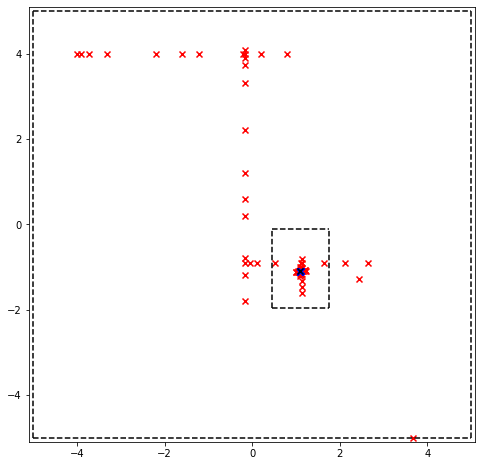

In [20]:
# Cube reduction

xmin, xmax = -5.0, 5.0
ymin, ymax = -5.0, 5.0

plt.figure(figsize=(8, 8))

plt.xlim(-5.1, 5.1)
plt.ylim(-5.1, 5.1)

plt.hlines([ymin, ymax], xmin, xmax, linestyles='dashed', color='black')
plt.vlines([xmin, xmax], ymin, ymax, linestyles='dashed', color='black')

# Perform several iterations within initial cube

@Wrapper(cache=True, nk=2, lb=[xmin, ymin], ub=[xmax, ymax], dk=[1.0E-12, 1.0E-12], error=1.0E-12)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

objective()
rcds = RCDS(objective, dr=1.0, ni=4, ktol=1.0E-12, otol=1.0E-12)
knobs = torch.tensor([-4.0, 4.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
_, knobs, value, *_ = rcds.fit_rcds(knobs, matrix, termination=True)

plt.scatter(*numpy.array(objective.cache_knobs).T, color='red', marker='x')

# New cube

lb, ub = rcds.adjust_cube()
xmin, ymin = lb
xmax, ymax = ub

plt.hlines([ymin, ymax], xmin, xmax, linestyles='dashed', color='black')
plt.vlines([xmin, xmax], ymin, ymax, linestyles='dashed', color='black')

# Perform several iterations within the new cube

knobs = objective.inverse(knobs[value == value.min()]).squeeze()

@Wrapper(cache=True, nk=2, lb=[xmin, ymin], ub=[xmax, ymax], dk=[1.0E-12, 1.0E-12], error=1.0E-12)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

objective()
rcds = RCDS(objective, dr=1.0, ni=4, ktol=1.0E-12, otol=1.0E-12)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
rcds.fit_rcds(knobs, matrix, termination=True)

plt.scatter(*numpy.array(objective.cache_knobs).T, color='blue', marker='x')
plt.scatter(1.10369, -1.10369, color='black', marker='x')
plt.show()

exit: triggered knobs termination at iteration 2
exit: triggered knobs termination at iteration 2
exit: triggered value termination at iteration 3


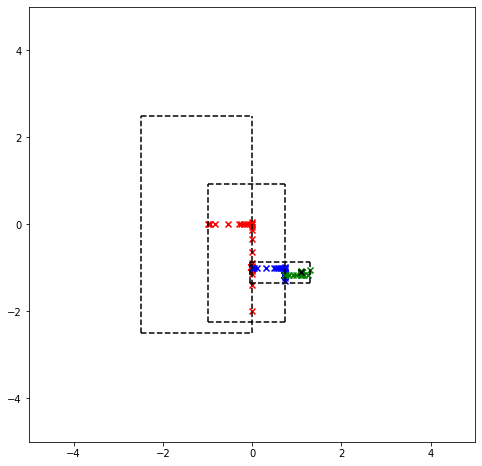

In [21]:
# Minimum outside of the cube

xmin, xmax = -2.5, 0.0
ymin, ymax = -2.5, 2.5

plt.figure(figsize=(8, 8))

plt.xlim(-5.0, 5.0)
plt.ylim(-5.0, 5.0)

plt.hlines([ymin, ymax], xmin, xmax, linestyles='dashed', color='black')
plt.vlines([xmin, xmax], ymin, ymax, linestyles='dashed', color='black')

@Wrapper(cache=True, nk=2, lb=[xmin, ymin], ub=[xmax, ymax], dk=[1.0E-12, 1.0E-12], error=1.0E-12)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

objective()
rcds = RCDS(objective, dr=1.0, ni=32, ktol=1.0E-12, otol=1.0E-12)
knobs = torch.tensor([-1.0, 0.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
_, knobs, value, *_ = rcds.fit_rcds(knobs, matrix, termination=True)
plt.scatter(*numpy.array(objective.cache_knobs).T, color='red', marker='x')

# New cube

lb, ub = rcds.adjust_cube(extend=True, factor=3.0, center_estimator=mean, spread_estimator=variance)
xmin, ymin = lb
xmax, ymax = ub

plt.hlines([ymin, ymax], xmin, xmax, linestyles='dashed', color='black')
plt.vlines([xmin, xmax], ymin, ymax, linestyles='dashed', color='black')

# Perform several iterations within the new cube

knobs, *_ = knobs[value == value.min()]
knobs = objective.inverse(knobs)

@Wrapper(cache=True, nk=2, lb=[xmin, ymin], ub=[xmax, ymax], dk=[1.0E-12, 1.0E-12], error=1.0E-12)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

objective()
rcds = RCDS(objective, dr=1.0, ni=32, ktol=1.0E-12, otol=1.0E-12)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
_, knobs, value, *_ = rcds.fit_rcds(knobs, matrix, termination=True)
plt.scatter(*numpy.array(objective.cache_knobs).T, color='blue', marker='x')

# New cube

lb, ub = rcds.adjust_cube(extend=True, factor=3.0, center_estimator=mean, spread_estimator=variance)
xmin, ymin = lb
xmax, ymax = ub

plt.hlines([ymin, ymax], xmin, xmax, linestyles='dashed', color='black')
plt.vlines([xmin, xmax], ymin, ymax, linestyles='dashed', color='black')

# Perform several iterations within the new cube

knobs, *_ = knobs[value == value.min()]
knobs = objective.inverse(knobs)

@Wrapper(cache=True, nk=2, lb=[xmin, ymin], ub=[xmax, ymax], dk=[1.0E-12, 1.0E-12], error=1.0E-12)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    error = torch.zeros_like(value)
    return value, error

objective()
rcds = RCDS(objective, dr=1.0, ni=32, ktol=1.0E-12, otol=1.0E-12)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
_, knobs, value, *_ = rcds.fit_rcds(knobs, matrix, termination=True)
plt.scatter(*numpy.array(objective.cache_knobs).T, color='green', marker='x')

plt.scatter(1.10369, -1.10369, color='black', marker='x')
plt.show()

# Example-06: RCDS continious optimization

In [22]:
# Define an objective with slow drift

@Wrapper(cache=True, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[1.0E-12, 1.0E-12], error=1.0E-12)
def objective(knobs):
    global time
    x, y = knobs
    value = (x - 1.0*time)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    time += 1.0E-3
    error = torch.zeros_like(value)
    return value, error

In [23]:
# Use large number of iterations without termination

time = 0.0
objective()
rcds = RCDS(objective, dr=0.99, ni=100, ktol=1.0E-6, otol=1.0E-6)

knobs = torch.tensor([-3.0, 4.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)

_, knobs, value, *_ = rcds.fit_rcds(knobs, matrix, termination=False)

knobs, value, error = objective.save()
time

1.5759999999999372

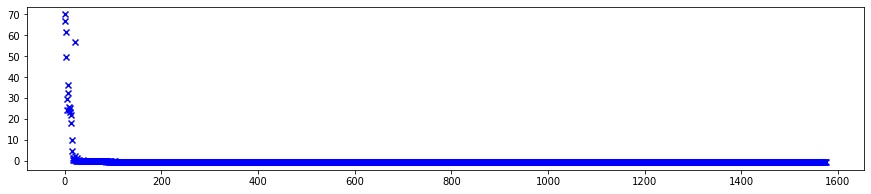

In [24]:
# Plot cached objective values

plt.figure(figsize=(15, 3))
plt.scatter(range(objective.n), value.cpu().numpy(), color='blue', marker='x')
plt.show()

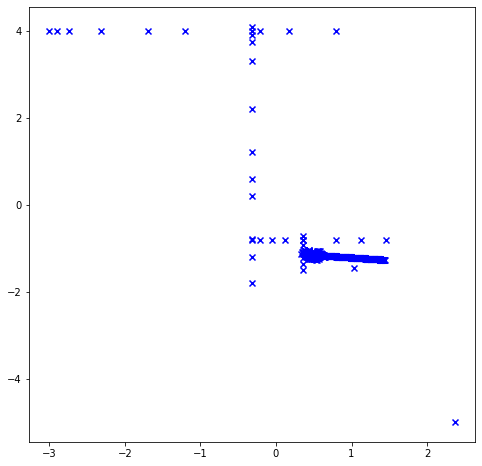

In [25]:
# Plot cached knobs

plt.figure(figsize=(8, 8))
plt.scatter(*knobs.T.cpu().numpy(), color='blue', marker='x')
plt.show()

In [26]:
# Use small numner of iterations in a loop
# Can include cude reduction

from time import sleep

time = 0.0
objective()

rcds = RCDS(objective, dr=0.99, ni=5, ktol=1.0E-6, otol=1.0E-6)

knobs = torch.tensor([-3.0, 4.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)

for _ in range(20):
    _, knobs, value, error, matrix = rcds.fit_rcds(knobs, matrix, termination=True)
    *_, knobs = knobs
    *_, value = value
    *_, matrix = matrix
    sleep(0.1)
    print(f'{knobs.cpu().numpy()} {value.cpu().numpy()}')
    
knobs, value, error = objective.save()
time

[0.54508071 0.38421778] -0.2731502447389559
[0.5505634  0.38587626] -0.3314324801343911
[0.55694397 0.38364684] -0.39124499108461064
[0.56332531 0.38470437] -0.44361724288726223
[0.56955662 0.38513644] -0.49461759762765356
[0.57602863 0.38557198] -0.5415154174328431
[0.58233581 0.38599582] -0.5815242744673523
[0.58819202 0.38638936] -0.6145966875104264
[0.59408354 0.38678528] -0.6436416902916455
[0.601158   0.38726069] -0.6731010698699145
[0.6077051  0.38770066] -0.6952867237163826
[0.61415134 0.38813386] -0.7125297669466385
[0.62049381 0.38856008] -0.7251999626701883
[0.62690635 0.38899101] -0.7339458665929341
[0.63406894 0.38947234] -0.7387313234970169
[0.63932332 0.38982545] -0.7391794564326464
[0.64380685 0.39012674] -0.7375898835964861
[0.64831074 0.39042941] -0.7341920716006989
[0.65268399 0.3907233 ] -0.7292117355303727
[0.65708083 0.39101877] -0.7223183922732558


1.64099999999993

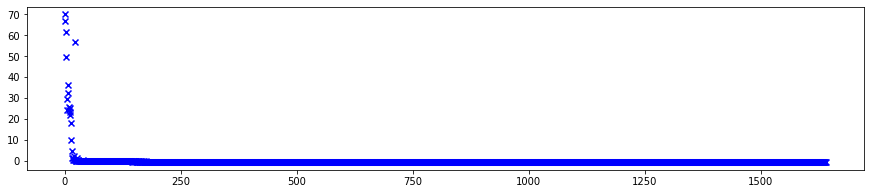

In [27]:
# Plot cached objective values

plt.figure(figsize=(15, 3))
plt.scatter(range(objective.n), value.cpu().numpy(), color='blue', marker='x')
plt.show()

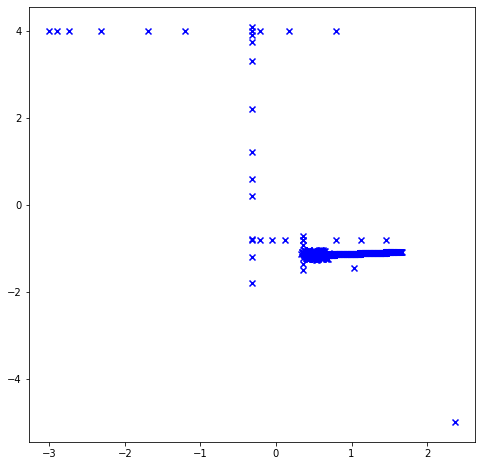

In [28]:
# Plot cached knobs

plt.figure(figsize=(8, 8))
plt.scatter(*knobs.T.cpu().numpy(), color='blue', marker='x')
plt.show()

# Example-07: RCDS with regularization

In [29]:
@Wrapper(nk=3, lb=[-5.0, -5.0, -5.0], ub=[+5.0, +5.0, +5.0], dk=[1.0E-12, 1.0E-12, 1.0E-12], error=1.0E-12)
def objective(knobs):
    x, y, z = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2 + 1.0E-6*(z - 1.0)**2
    error = torch.zeros_like(value)
    return value, error

# Normal

objective()
rcds = RCDS(objective, dr=1.0, ni=32, ktol=1.0E-6, otol=1.0E-6)
knobs = torch.tensor([-3.0, 4.0, -5.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
_, knobs, value, *_ = rcds.fit_rcds(knobs, matrix, termination=True)
*_, knobs = knobs
*_, value = value

print(*objective.inverse(knobs).cpu().numpy(), value.cpu().numpy())
print()

# L1

@Wrapper(nk=3, lb=[-5.0, -5.0, -5.0], ub=[+5.0, +5.0, +5.0], dk=[1.0E-12, 1.0E-12, 1.0E-12], error=1.0E-12, alpha_l1=1.0E-2)
def objective(knobs):
    x, y, z = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2 + 1.0E-6*(z - 1.0)**2
    error = torch.zeros_like(value)
    return value, error

objective()
rcds = RCDS(objective, dr=1.0, ni=32, ktol=1.0E-6, otol=1.0E-6)
knobs = torch.tensor([-3.0, 4.0, -5.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
_, knobs, value, *_ = rcds.fit_rcds(knobs, matrix, termination=True)
*_, knobs = knobs
*_, value = value

print(*objective.inverse(knobs).cpu().numpy(), value.cpu().numpy())
print()

# L3

@Wrapper(nk=3, lb=[-5.0, -5.0, -5.0], ub=[+5.0, +5.0, +5.0], dk=[1.0E-12, 1.0E-12, 1.0E-12], error=1.0E-12, alpha_l2=1.0E-2)
def objective(knobs):
    x, y, z = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2 + 1.0E-6*(z - 1.0)**2
    error = torch.zeros_like(value)
    return value, error

objective()
rcds = RCDS(objective, dr=1.0, ni=32, ktol=1.0E-6, otol=1.0E-6)
knobs = torch.tensor([-3.0, 4.0, -5.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
_, knobs, value, *_ = rcds.fit_rcds(knobs, matrix, termination=True)
*_, knobs = knobs
*_, value = value

print(*objective.inverse(knobs).cpu().numpy(), value.cpu().numpy())
print()

exit: triggered value termination at iteration 5
1.1024340185297348 -1.103713410632877 0.9999999967185582 -0.7020112845857034

exit: triggered value termination at iteration 5
1.1011400305945696 -1.1006940186627174 0.0005010668481624236 -0.679962561660766

exit: triggered knobs termination at iteration 4
1.097668860970753 -1.0971991310160334 9.999000103544375e-05 -0.6777908177201373



# Example-08: GP minimization (1D)

In [30]:
# In this example GP is used for 1D minimization

In [31]:
from botorch.models import SingleTaskGP
from botorch.models import FixedNoiseGP
from botorch.fit import fit_gpytorch_model
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.analytic import UpperConfidenceBound
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

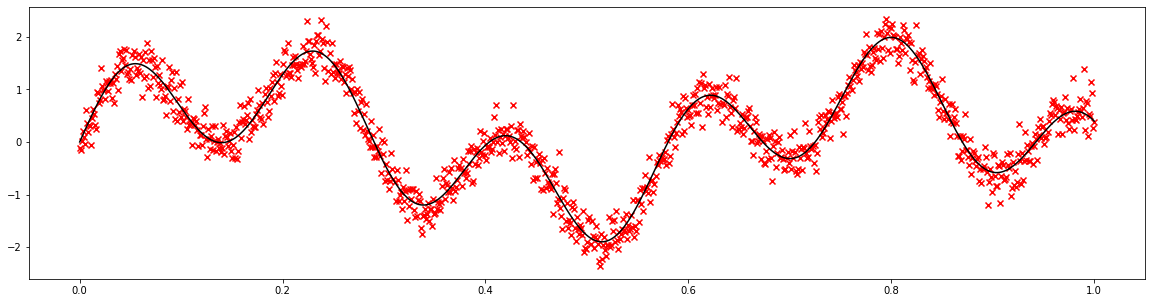

In [32]:
# Define objective function

@Wrapper(nk=1, lb=[0.0], ub=[10.0], dk=[0.0], error=0.25, dtype=dtype, device=device)
def objective(knobs):
    x, *_ = knobs
    value = torch.sin(x) + torch.sin((10.0/3.0)*x)
    global error
    if error:
        value += objective.error*torch.randn_like(value)
    return value, objective.error
objective()

# Plot objective function

plt.figure(figsize=(20, 5))

error = False
x1 = torch.linspace(0.0, 1.0, 1000)
y1, _ = torch.tensor([objective(knobs) for knobs in x1]).T
plt.plot(x1, y1, color='black')

error = True
x2 = torch.linspace(0.0, 1.0, 1000)
y2, _ = torch.tensor([objective(knobs) for knobs in x2]).T
plt.scatter(x2, y2, color='red', marker='x')

plt.show()

In [33]:
%%time

# SingleTaskGP optimization loop
# Perform 1 initial observation
# 100 observations with ExpectedImprovement
# 100 observations with UpperConfidenceBound

# Reset objective

objective()

# Set number of initial observations

ns = 1

# Generate initial knobs
# x -- original knobs, X -- rescaled knobs

x = torch.rand((ns, 1), dtype=dtype, device=device)*(objective.lb - objective.ub) + objective.ub
X = torch.stack([objective.forward(knobs) for knobs in x])

# Generate initial observations
# y -- objective values, Y -- standardized objective values

y, _ = torch.tensor([objective(knobs) for knobs in X]).T
Y = ((y - y.mean())/y.std()).nan_to_num()

# Define GP model

gp = SingleTaskGP(X, Y.reshape(-1, 1))

# Define likelihood

ll = ExactMarginalLogLikelihood(gp.likelihood, gp)

# Fit

fit_gpytorch_model(ll)

# Set number of optimization observations

no = 200

# Optimization loop

for i in range(no):
    
    # Set current best observation
    
    best = torch.min(Y)
    
    # Set acquisition function
    
    af = ExpectedImprovement(gp, best, maximize=False) if i < 100 else UpperConfidenceBound(gp, 1.0, maximize=False)
    
    # Optimize acquisition function
    
    candidate, _ = optimize_acqf(
        af,
        bounds = torch.tensor([[0.0], [1.0]], dtype=dtype, device=device),
        num_restarts = 32,
        q = 1,
        raw_samples = 128
    )
    candidate = candidate.flatten()
    
    # Perform observation for found candidate
    
    value, error = objective(candidate)
    
    # Add candidate to knobs
    
    x = torch.cat([x, objective.inverse(candidate).reshape(-1, 1)])
    X = torch.cat([X, candidate.reshape(-1, 1)])
    
    # Add objective value
    
    y = torch.cat([y, value.flatten()])
    
    # Standardize
    
    Y = ((y - y.mean())/y.std()).nan_to_num()
    
    # Update & fit model
    
    gp = SingleTaskGP(X, Y.reshape(-1, 1))
    ll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(ll)
    
    # Continue

CPU times: user 3min 51s, sys: 10.3 s, total: 4min 1s
Wall time: 40.3 s


In [34]:
# Number of objective evaluations

print(objective.n)

# Best solution

index = y.argmin()
print(f'knobs={X[index].cpu().numpy()}')
print(f'value={y[index].cpu().numpy()}')

201
knobs=[0.51125773]
value=-2.3435120070461313


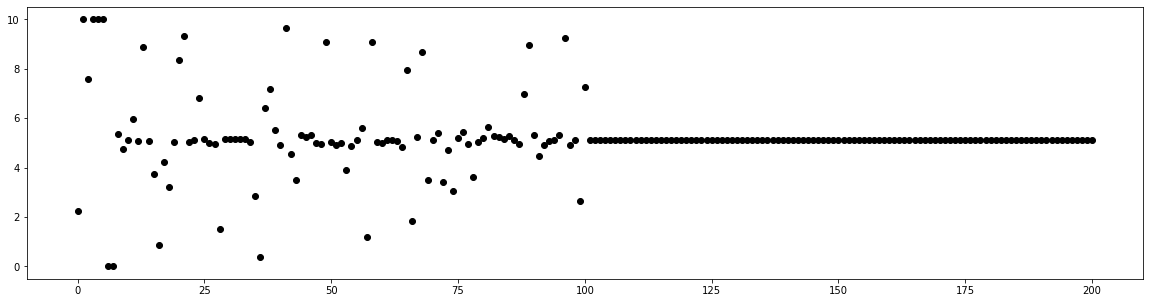

In [35]:
# Plot knob value vs time

plt.figure(figsize=(20, 5))
plt.scatter(range(objective.n), x.cpu().numpy(), color='black')
plt.show()

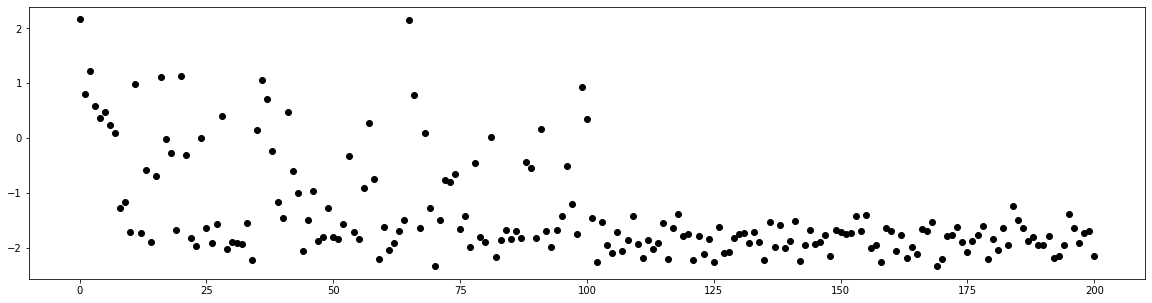

In [36]:
# Plot objective value vs time

plt.figure(figsize=(20, 5))
plt.scatter(range(objective.n), y.cpu().numpy(), color='black')
plt.show()

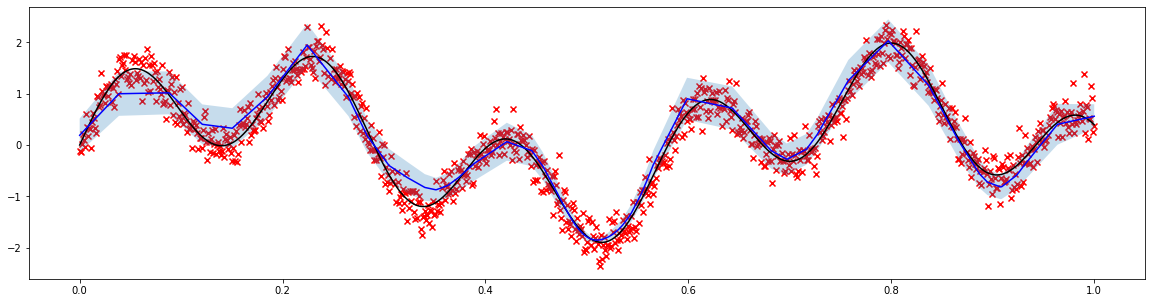

In [37]:
# Compute and plot confidence region

with torch.no_grad():
    p = gp.posterior(X, Y)
    m = p.mean.flatten()
    l, u = p.mvn.confidence_region()
    l = l.flatten()
    u = u.flatten()
    
# Sort and perform inverse standartization

index = X.flatten().argsort()
m = m[index]*y.std() + y.mean()
l = l[index]*y.std() + y.mean()
u = u[index]*y.std() + y.mean()

# Plot

plt.figure(figsize=(20, 5))
plt.plot(x1, y1, color='black')
plt.scatter(x2, y2, color='red', marker='x')
plt.plot(X.flatten()[index], m, color='blue')
plt.fill_between(X.flatten()[index], l, u, alpha = 0.25, lw = 0)
plt.show()

In [38]:
%%time

# FixedNoiseGP optimization loop
# Perform 1 initial observation
# 100 observations with ExpectedImprovement
# 100 observations with UpperConfidenceBound

# Reset objective

objective()

# Set number of initial observations

ns = 1

# Generate initial knobs
# x -- original knobs, X -- rescaled knobs

x = torch.rand((ns, 1), dtype=dtype, device=device)*(objective.lb - objective.ub) + objective.ub
X = torch.stack([objective.forward(knobs) for knobs in x])

# Generate initial observations
# y -- objective values, Y -- standardized objective values

y, s = torch.tensor([objective(knobs) for knobs in X]).T
Y = ((y - y.mean())/y.std()).nan_to_num()
S = (s/y.std()).nan_to_num()

# Define GP model

gp = FixedNoiseGP(X, Y.reshape(-1, 1), S.reshape(-1, 1))

# Define likelihood

ll = ExactMarginalLogLikelihood(gp.likelihood, gp)

# Fit

fit_gpytorch_model(ll)

# Set number of optimization observations

no = 200

# Optimization loop

for i in range(no):
    
    # Set current best observation
    
    best = torch.min(Y)
    
    # Set acquisition function
    
    af = ExpectedImprovement(gp, best, maximize=False) if i < 100 else UpperConfidenceBound(gp, 1.0, maximize=False)
    
    # Optimize acquisition function
    
    candidate, _ = optimize_acqf(
        af,
        bounds = torch.tensor([[0.0], [1.0]], dtype=dtype, device=device),
        num_restarts = 32,
        q = 1,
        raw_samples = 128
    )
    candidate = candidate.flatten()
    
    # Perform observation for found candidate
    
    value, error = objective(candidate)
    
    # Add candidate to knobs
    
    x = torch.cat([x, objective.inverse(candidate).reshape(-1, 1)])
    X = torch.cat([X, candidate.reshape(-1, 1)])
    
    # Add objective value
    
    y = torch.cat([y, value.flatten()])
    s = torch.cat([s, error.flatten()])
    
    # Standardize
    
    Y = ((y - y.mean())/y.std()).nan_to_num()
    S = (s/y.std()).nan_to_num()
    
    # Update & fit model
    
    gp = FixedNoiseGP(X, Y.reshape(-1, 1), S.reshape(-1, 1))
    ll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(ll)
    
    # Continue

CPU times: user 2min 17s, sys: 5.78 s, total: 2min 23s
Wall time: 24 s


In [39]:
# Number of objective evaluations

print(objective.n)

# Best solution

index = y.argmin()
print(f'knobs={X[index].cpu().numpy()}')
print(f'value={y[index].cpu().numpy()}')

201
knobs=[0.51595305]
value=-2.4034628027190337


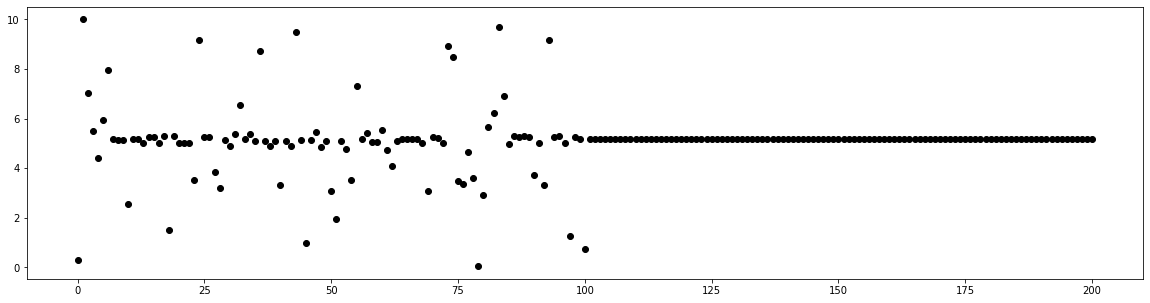

In [40]:
# Plot knob value vs time

plt.figure(figsize=(20, 5))
plt.scatter(range(objective.n), x.cpu().numpy(), color='black')
plt.show()

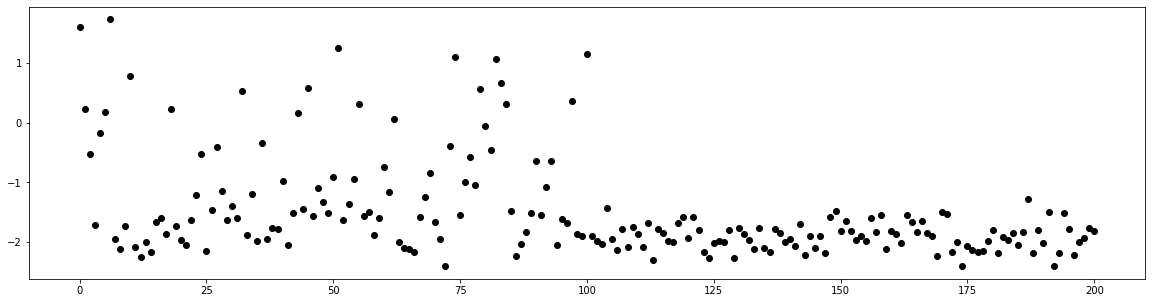

In [41]:
# Plot objective value vs time

plt.figure(figsize=(20, 5))
plt.scatter(range(objective.n), y.cpu().numpy(), color='black')
plt.show()

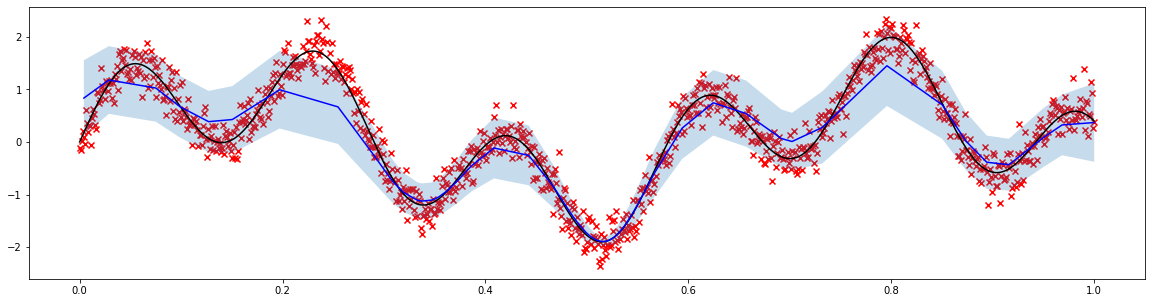

In [42]:
# Compute and plot confidence region

with torch.no_grad():
    p = gp.posterior(X, Y)
    m = p.mean.flatten()
    l, u = p.mvn.confidence_region()
    l = l.flatten()
    u = u.flatten()
    
# Sort and perform inverse standartization

index = X.flatten().argsort()
m = m[index]*y.std() + y.mean()
l = l[index]*y.std() + y.mean()
u = u[index]*y.std() + y.mean()

# Plot

plt.figure(figsize=(20, 5))
plt.plot(x1, y1, color='black')
plt.scatter(x2, y2, color='red', marker='x')
plt.plot(X.flatten()[index], m, color='blue')
plt.fill_between(X.flatten()[index], l, u, alpha = 0.25, lw = 0)
plt.show()

# Example-09: GP minimization (ND)

In [43]:
# In this example GP is used for ND minimization

In [44]:
from botorch.models import SingleTaskGP
from botorch.models import FixedNoiseGP
from botorch.fit import fit_gpytorch_model
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.acquisition.analytic import UpperConfidenceBound
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

In [45]:
# Define objective function

nk = 3
lb = [-10.0 for _ in range(nk)]
ub = [+10.0 for _ in range(nk)]
dk = [1.0E-3 for _ in range(nk)]

@Wrapper(nk=nk, lb=lb, ub=ub, dk=dk, error=1.0E-6)
def objective(knobs:torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    value = torch.zeros_like(knobs.sum())
    error = torch.zeros_like(knobs.sum())
    for i in range(len(knobs) - 1):
        value -= 10.0*torch.exp(-0.25*torch.sqrt(knobs[i]**2 + knobs[i + 1]**2))
    return value, error
objective()

In [46]:
# Fit with powell

rcds = RCDS(objective)
knobs = torch.tensor([1.0 for _ in range(rcds.nk)], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
result = rcds.fit_scipy(knobs)
print(result.fun)
print(result.x)

-20.0
[0.5 0.5 0.5]


In [47]:
%%time

# SingleTaskGP optimization loop

# Reset objective

objective()

# Set number of initial observations

ns = 1

# Generate initial knobs
# x -- original knobs, X -- rescaled knobs

x = torch.rand((ns, nk), dtype=dtype, device=device)*(objective.lb - objective.ub) + objective.ub
X = torch.stack([objective.forward(knobs) for knobs in x])

# Generate initial observations
# y -- objective values, Y -- standardized objective values

y, _ = torch.tensor([objective(knobs) for knobs in X]).T
Y = ((y - y.mean())/y.std()).nan_to_num()

# Define GP model

gp = SingleTaskGP(X, Y.reshape(-1, 1))

# Define likelihood

ll = ExactMarginalLogLikelihood(gp.likelihood, gp)

# Fit

fit_gpytorch_model(ll)

# Set number of optimization observations

no = 200

# Optimization loop

for i in range(no):
    
    # Set current best observation
    
    best = torch.min(Y)
    
    # Set acquisition function
        
    af = ExpectedImprovement(gp, best, maximize=False) if i < 100 else UpperConfidenceBound(gp, 1.0, maximize=False)
    
    # Optimize acquisition function
    
    candidate, _ = optimize_acqf(
        af,
        bounds = torch.stack([torch.zeros_like(objective.lb), torch.ones_like(objective.ub)]),
        num_restarts = 32,
        q = 1,
        raw_samples = 128
    )
    candidate = candidate.flatten()
    
    # Perform observation for found candidate
    
    value, error = objective(candidate)
    
    # Add candidate to knobs
    
    x = torch.cat([x, objective.inverse(candidate).reshape(1, -1)])
    X = torch.cat([X, candidate.reshape(1, -1)])
    
    # Add objective value
    
    y = torch.cat([y, value.flatten()])
    
    # Standardize
    
    Y = ((y - y.mean())/y.std()).nan_to_num()
    
    # Update & fit model
    
    gp = SingleTaskGP(X, Y.reshape(-1, 1))
    ll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(ll)
    
    # Continue

CPU times: user 15min 28s, sys: 41.5 s, total: 16min 9s
Wall time: 2min 41s


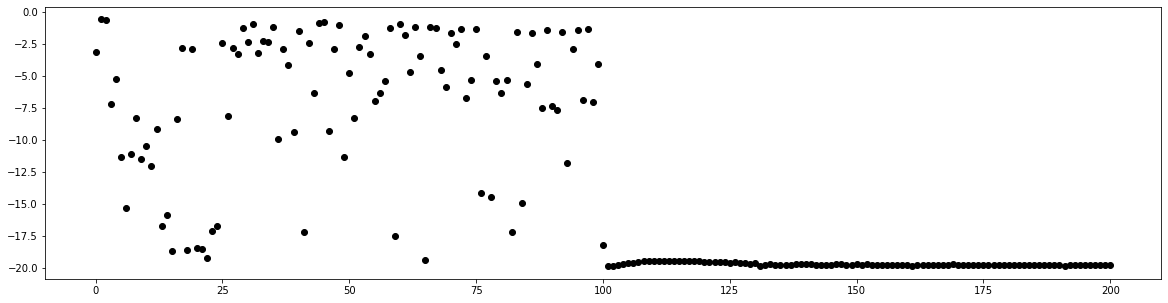

In [48]:
# Plot objective value vs time

plt.figure(figsize=(20, 5))
plt.scatter(range(objective.n), y.cpu().numpy(), color='black')
plt.show()

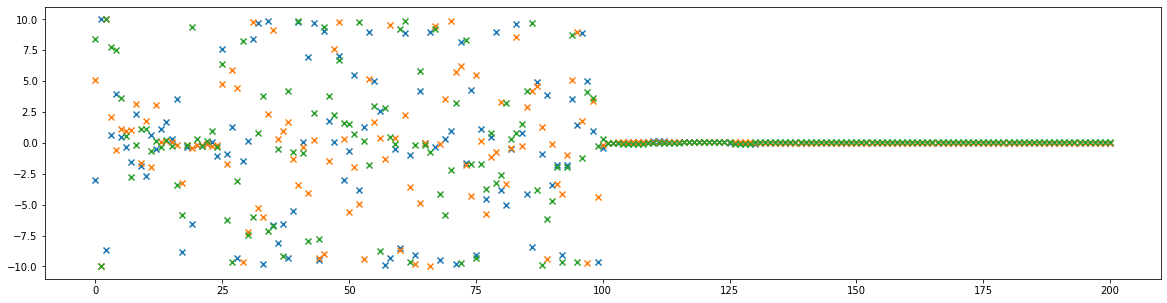

In [49]:
# Plot knobs vs time

plt.figure(figsize=(20, 5))
for k in x.T.cpu().numpy():
    plt.scatter(range(objective.n), k, marker='x')
plt.show()

# Example-10: RCDS with GP

In [50]:
# Minimize (bracketting + parabola with additional samples)

# Define objective {-0.702014, {x->1.10369, y->-1.10369}}

@Wrapper(cache=True, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[1.0E-12, 1.0E-12], error=1.0E-6)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    value += objective.error*torch.randn_like(value) 
    error = objective.error
    return value, error

# Minimize

objective()
rcds = RCDS(objective, dr=1.0, ni=10, ktol=1.0E-3, otol=1.0E-3)
knobs = torch.tensor([-3.0, 4.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
rcds.fit_rcds(knobs, matrix, termination=True)
_, value1, _ = objective.save()

exit: triggered knobs termination at iteration 4


In [51]:
# Minimize (gp + 3 point parabola without additional samples)

# Define objective {-0.702014, {x->1.10369, y->-1.10369}}

@Wrapper(cache=True, nk=2, lb=[-5.0, -5.0], ub=[+5.0, +5.0], dk=[1.0E-12, 1.0E-12], error=1.0E-6)
def objective(knobs):
    x, y = knobs
    value = (x - 1.0)**2 + (y + 1.0)**2 + x*y + 1.0/3.0*x**2*y**2
    value += objective.error*torch.randn_like(value) 
    error = objective.error
    return value, error

# Minimize

objective()
rcds = RCDS(objective, dr=1.0, ni=10, ktol=1.0E-3, otol=1.0E-3)
knobs = torch.tensor([-3.0, 4.0], dtype=rcds.dtype)
knobs = objective.forward(knobs)
matrix = torch.eye(rcds.nk, dtype=rcds.dtype)
rcds.fit_rcds(knobs, matrix, termination=True, minimize=rcds.minimize_gp, no_ei=8, no_ucb=2, nr=64, rs=256, np=1, beta=0.5)
_, value2, _ = objective.save()

exit: triggered knobs termination at iteration 4


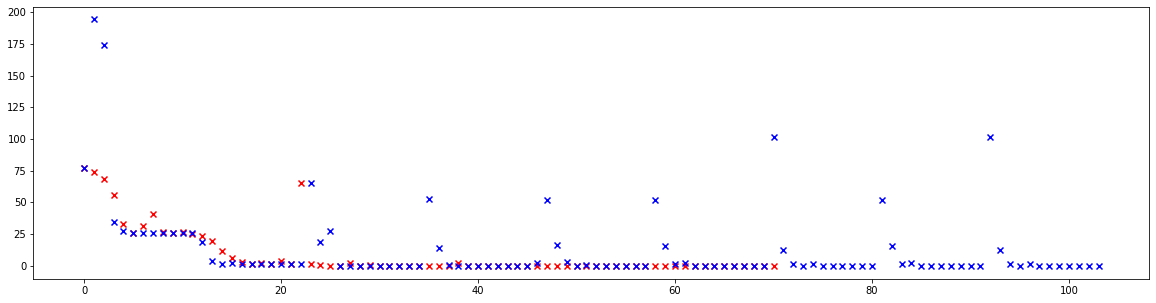

In [52]:
# Plot objective history

plt.figure(figsize=(20, 5))
plt.scatter(range(len(value1)), value1.cpu().numpy(), color='red', marker='x')
plt.scatter(range(len(value2)), value2.cpu().numpy(), color='blue', marker='x')
plt.show()